In [96]:
import numpy as np
import pickle, torch, random
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch import nn

from matplotlib import pyplot as plt
from copy import deepcopy

In [97]:
#def set_seed(seed = 42):
#    random.seed(seed)
#    np.random.seed(seed)
#    torch.manual_seed(seed) 
#    torch.cuda.manual_seed(seed)

#def seed_worker(worker_id): 
    # https://pytorch.org/docs/master/notes/randomness.html#dataloader - for reproducibility
#    worker_seed = torch.initial_seed() % 2**32
#    numpy.random.seed(worker_seed)
#    random.seed(worker_seed)


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [98]:
def givemereward(original, predicted):
    
    '''
      original: right decision
      predicted: model output for the decision
    '''
    
    #print('predicted before: ', predicted.size(), predicted)
    predicted = predicted.argmax(dim=1) 
    #print('predicted after: ', predicted.size(), predicted)
    #print('orig: ', original.size(), original)
    
    reward = abs(original - predicted)
    " 0 is succesfull, 1 is error"

    return nn.functional.one_hot(reward) # converting to one-hot

In [99]:
def prep_data(data, dt):
    
    '''
    - increases the resolution of trials from 1 step/trial to (6/dt) step/trial
      -> 6 sec is the examined time range: - 1.5 sec before stimulus (context info only)
                                           - the 3 sec of stimulus (context + stimulus info)
                                           - 1.5 sec after stimulus (context info only)
    '''
    
    mask_out = torch.ones(data.size())
    mask_out[:,:,2:] = 0 # context information only - no signal yet
    x_out = mask_out*data
    seq_length = (4.5+1.5)/dt # 1.5 + 3 + 1.5 = 6 sec - range examined
    block1 = int(seq_length/2) # 3 sec - duration of stimulus 
    block2 = int(seq_length/4) # 1.5 sec - before and after stim
    block_out = torch.cat((x_out,)*block2,dim=1)
    block_stim = torch.cat((data,)*block1,dim=1)
    data = torch.cat((block_out,block_stim,block_out),dim=1) 
    
    return data

In [100]:
def make_data(S, inc = False): 
    
    class dataset(Dataset):
        def __init__(self, S):
            
            '''
               S: trials per block = how many trials are within a given sequence
                  overall number of trials depends on S (to cover all possible combinations):
                     - n_trials (n) = 4^S + 4^S (corresponding to the 2 different context)
                     - n_trials (n) = 2^S + 2^S for incongruent trials only 
                     - example: S=2 -> n = 4x4 + 4x4 OR n = 2x2 + 2x2
               inc: bool - if True: incongruent trials only 
                         - deafult False: all possible trial combinations (conr + incongr as well)
            '''
            
            if inc:
                n_comb = 2 # 2 possible combinations for each context
                index_list = [0,1]
            else:
                n_comb = 4 # 4 possible combinations for each context
                index_list = [0,1,2,3]
            # = n_comb^S combinations 
    
            sequences = np.zeros((n_comb**(S), S))
            sequences[:, 0] =  np.concatenate([index_list]*n_comb**(S-1))
            list_next = index_list
    
            for s in range(1,S):
                list_next = np.repeat(list_next, n_comb)
                sequences[:, s] = np.concatenate([list_next]*n_comb**(S-s-1))
    
            if inc: 
                # all possible trial combinations in one-hot encoded form:
                variations_onehot = np.array([[[1,0,0,1]],[[0,1,1,0]]]) # the 2 incongrent trials
                # correct decisions for both context
                # 1 = go vs 0 = nogo
                id_dec_aud = np.array([1,0])
                id_dec_vis = np.array([0,1])
            else:
                variations_onehot = np.array([[[1,0,1,0]],[[1,0,0,1]],[[0,1,1,0]],[[0,1,0,1]]])
                # (aud go, vis go), (aud go, vis nogo), (aud nogo, vis go), (aud nogo, vis nogo) = 
                # corresponding ideal (correct) decisions = 1, 1, 0, 0 - if context audio
                # corresponding ideal (correct) decisions = 1, 0, 1, 0 - if context visual
                id_dec_aud = np.array([1,1,0,0])  
                id_dec_vis = np.array([1,0,1,0])
    
            data_onehot = variations_onehot[list(map(int,sequences[:,0]))]
            d_aud_list = [id_dec_aud[list(map(int,sequences[:,0]))]]
            d_vis_list = [id_dec_vis[list(map(int,sequences[:,0]))]]
    
            for s in range(1,S):
                data_onehot = np.concatenate([data_onehot, variations_onehot[list(map(int,sequences[:,s]))]], axis = 1)
        
                d_aud_list.append(id_dec_aud[list(map(int,sequences[:,s]))])
                d_vis_list.append(id_dec_vis[list(map(int,sequences[:,s]))])

            data_onehot = np.concatenate([data_onehot, data_onehot]) # same pattern for the both context
    
            d_aud = np.vstack(d_aud_list).transpose()
            d_vis = np.vstack(d_vis_list).transpose()
            decision = np.concatenate([d_aud, d_vis])
            
            self.data_onehot = torch.tensor(data_onehot) 
            # of size: (#trials, #trials_per_block, #features=aud_go/nogo,vis_go/nogo)
            self.decision = torch.tensor(decision) 
            # of size: (#trials, #trials_per_block)
        
        def __len__(self):
            return len(self.decision)

        def __getitem__(self, idx, type='natural'):
            return self.data_onehot[idx], self.decision[idx]
    
        
    return dataset(S)

In [101]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.rnn = nn.RNNCell(
            input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, objective):
        
        '''
          x: dataset from make_data() + batched with dataloader -> batched stimulus 
             - of size = (batch size, trials_per_block, 4) (4: corresponds to one-hot a/v signals)
             - each row corresponds to a sequence (block)
             - last trial within a sequence is used to calculate loss
          objective: correct decision (1 = go vs 0 = nogo)
             - of size = (batch size, trials_per_block)
        '''

        #print('x.size', x.size())
        hx = torch.randn(x.size(0), self.hidden_dim).requires_grad_() 
        #print('hx', hx.size())
        reward = torch.zeros(x.size(0), 2).requires_grad_() # 2 for one-hot encoded reward 
        
        for t in range(x.size(1)): # going through trials within the sequence/block
        
            rnn_input = torch.zeros(1, x.size(0), self.input_dim)
            rnn_input[0,:,0:4] = x[:,t,:] 
            rnn_input[0,:,4:6] = reward           
            rnn_input = rnn_input.permute(1, 0, 2)
            rnn_input = prep_data(rnn_input, 0.3)
            out = [hx] 
            y_out = [self.fc(hx).detach().numpy()] 
        
            for i in range(rnn_input.size(1)): # going through within trial times 
                #hx = self.rnn(rnn_input[i,:,:], hx) #- old
                hx = self.rnn(rnn_input[:,i,:], hx) 
                out.append(hx)
                y_out.append(self.fc(hx).detach().numpy()) 
            
            out = torch.stack(out)

            rnn_out = out[11, :, :] # 2 sec + its overwritten after every inter sequence trial
                                    # meaning only the last inter sequence trial is used to calculate loss

            rnn_out = self.fc(rnn_out) # y_hat
            
            reward = givemereward(objective[:,t], rnn_out) # we have to know the correct context dependent 
                                                           # decision in order to calculate reward that
                                                           # can't be random
        
        return rnn_out
   

In [102]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer, log = False):
        
        self.model = model
        self.loss_fn = loss_fn # criterion
        self.optimizer = optimizer
        self.log = log
        
        self.train_loss, self.test_loss = [], []
        self.train_acc, self.test_acc = [], []
    
    def train(self, train_loader, test_loader): 

        for epoch in range(n_epochs):
            if self.log:
                print(f'Epoch {epoch}\n')
            
            correct_train, loss_train = 0, 0
            
            for i,(input, objective) in enumerate(train_loader): # objective = decision
            
                input = input.to(device)
                objective = objective.to(device)
            
                self.model.train()
            
                output = self.model(input, objective)
                output = nn.functional.softmax(output, dim=1)

                # only last inter sequence trial is used to calculate loss
                objective = torch.unsqueeze(objective[:,-1],1).to(device) 
                objective = objective.squeeze()
                loss = self.loss_fn(output.float(), objective.long())
                loss_train += loss
                correct_train += (output.argmax(dim=1) == objective).sum().item()
            
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
                if (i+1) % (len(train_loader)//3) == 0 and self.log:
                    print (f'Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                    
            loss_train /= len(train_loader)
            correct_train /= len(train_loader.dataset)
            
            self.train_loss.append(loss_train.detach().numpy())
            self.train_acc.append(100*correct_train)
        
            correct_test, loss_test = 0, 0 # egy loss es egy acc mert 1 epoch-ra szamol
        
            with torch.no_grad():
            
                for i, (input, objective) in enumerate(test_loader):
                    
                    input = input.to(device)
                    objective = objective.to(device)
                    
                    self.model.eval()
                
                    output = self.model(input, objective)
                    
                    objective = torch.unsqueeze(objective[:,-1],1)#.to(self.cpu)
                    objective = objective.squeeze()
                  #  loss_test += self.loss_fn(nn.functional.softmax(output,dim=1).float(),objective.long())
                    loss_test += self.loss_fn(output.float(), objective.long())
                    correct_test += (output.argmax(dim=1) == objective).sum().item()

                loss_test /= len(test_loader)
                correct_test /= len(test_loader.dataset)    
                
                self.test_loss.append(loss_test.detach().numpy())
                self.test_acc.append(100*correct_test)
            
                if self.log:
                    print(f"Accuracy: {(100*correct_test):>0.1f}%, Avg loss: {loss_test:>8f}")
                
    def plot_losses(self, path = ''):
        fig, ax = plt.subplots(1,2,figsize = (13,4))
        ax[0].plot(self.train_loss, label="Train loss")
        ax[0].plot(self.test_loss, label="Test loss")
        ax[0].legend()
        ax[0].set_title("Losses")
        ax[0].set_xlabel("# epoch")
        
        ax[1].plot(self.train_acc, label="Train accuracy")
        ax[1].plot(self.test_acc, label="Test accuracy")
        ax[1].legend()
        ax[1].set_title("Accuracy")
        ax[1].set_xlabel("# epoch")
        
        fig.tight_layout()
        if bool(path): 
            plt.savefig(path + '.png')
            

In [103]:
n_epochs = 100 #100
train_blocks = 100 # block = sequence - 100
test_blocks = 10 # 10
trials_per_block = 4 # 8
learning_rate = 1e-4 # 1e-4
weight_decay = 1e-4 #1e-4


input_dim = 6 # aud, vis onehot + reward onehot
hidden_dim = 8 # number of neurons (16)
output_dim = 2 
batch_size = 8 # 4

train_dataset = make_data(trials_per_block, inc = False)
test_dataset = make_data(trials_per_block, inc = False)

train_loader = DataLoader(train_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

model = RNNModel(input_dim, hidden_dim, output_dim)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

opt = Optimization(model = model, loss_fn = loss_fn, optimizer = optimizer, log = False)

In [104]:
#stimulus, objective = next(iter(train_loader))

In [105]:
%%time
opt.train(train_loader, test_loader)

CPU times: user 1min 11s, sys: 885 ms, total: 1min 12s
Wall time: 1min 12s


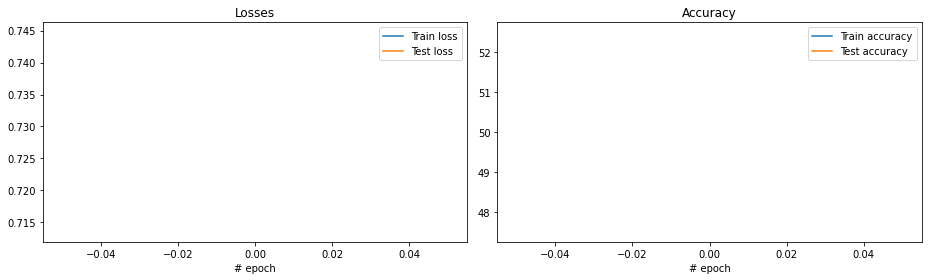

In [90]:
opt.plot_losses()